In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [2]:
data=pd.read_csv('rfm')

In [3]:
data.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [4]:
data

,CustomerID,Monetary,Frequency,Recency,Monetary_score,Frequency_score,Recency_score,rfm_score,Status
0,12346.0,77183.60,1,325,5,1,1,115,Cannot Lose Them
1,12347.0,4310.00,182,1,5,5,5,555,Champions
2,12348.0,1797.24,31,74,4,3,2,234,At Risk
3,12349.0,1757.55,73,18,4,4,4,444,Loyal
4,12350.0,334.40,17,309,2,2,1,122,Hibernating customers
...,...,...,...,...,...,...,...,...,...
4333,18280.0,180.60,10,277,1,1,1,111,Lost customers
4334,18281.0,80.82,7,180,1,1,1,111,Lost customers
4335,18282.0,178.05,12,7,1,1,5,511,New Customers
4336,18283.0,2094.88,756,3,5,5,5,555,Champions


<AxesSubplot:>

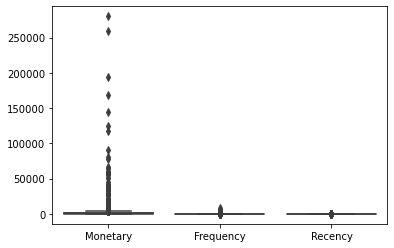

In [5]:
sns.boxplot(data=data[['Monetary','Frequency','Recency']])

<AxesSubplot:>

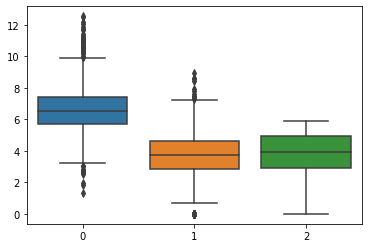

In [6]:
sns.boxplot(data=[np.log(data['Monetary']),np.log(data['Frequency']),np.log(data['Recency']+1)])

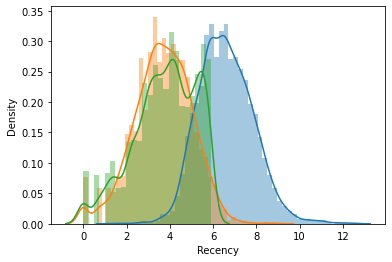

In [7]:
sns.distplot(np.log(data['Monetary']))
sns.distplot(np.log(data['Frequency']))
sns.distplot(np.log(data['Recency']+1))
plt.show()

**Let's try modelling in multiple ways:**
1. remove outliers and treat with k means
2. use mechanism like dbscan or hierarchical clustering with may be log normalized data or with the original data

# K means

In [8]:
data_out_rem=data[['CustomerID','Recency','Frequency','Monetary']]

In [9]:
for a in data_out_rem.drop('CustomerID',axis=1).columns:
    q1=data_out_rem[a].quantile(0.05)
    q3=data_out_rem[a].quantile(0.95)
    iqr=q3-q1
    data_out_rem=data_out_rem[(data_out_rem[a]>q1-1.5*iqr) & (data_out_rem[a]<q3+1.5*iqr)]

In [10]:
data_out_rem

,CustomerID,Recency,Frequency,Monetary
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40
5,12352.0,35,85,2506.04
...,...,...,...,...
4333,18280.0,277,10,180.60
4334,18281.0,180,7,80.82
4335,18282.0,7,12,178.05
4336,18283.0,3,756,2094.88


<AxesSubplot:xlabel='Monetary', ylabel='Density'>

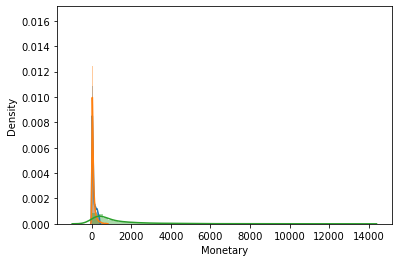

In [11]:
sns.distplot(data_out_rem['Recency'])
sns.distplot(data_out_rem['Frequency'])
sns.distplot(data_out_rem['Monetary'])

**Scaling the data using robust,min max and standard scaler**

In [12]:
plt.figure(figsize=(12,10))

def km_analyse(data):
    l=[]
    sil=[]
    cal=[]
    for i in range(1,13):
        km=KMeans(n_clusters=i)
        km.fit(data)
        l.append(km.inertia_)
        if i>1:
            cluster_label=km.labels_
            sil.append(silhouette_score(data,cluster_label))
            cal.append(calinski_harabasz_score(data,cluster_label))
        
    print('Error list: ',l)
    plt.plot(range(1,13),l)
    sil_data=pd.DataFrame()
    sil_data['Cluster']=range(2,13)
    sil_data['Silhouette_score']=sil
    print('Silhouette_score:\n',sil_data)
    print('Calinski Harabasz score:\n',pd.DataFrame({'Cluster': range(2,13),'CH score':cal}))

def km_model_eval(n,data):
    km=KMeans(n_clusters=n)
    km.fit(data)
    print('Cluster Labels:\n',km.labels_)
    return km.labels_

<Figure size 864x720 with 0 Axes>

Standard Scaler

In [13]:
sc=StandardScaler()
data_out_rem_std=pd.DataFrame(sc.fit_transform(data_out_rem[['Recency','Frequency','Monetary']]))

Error list:  [12764.999999999982, 7619.977670395139, 4427.871816487319, 3372.454735635572, 2804.4730234192784, 2405.6906958175746, 2052.6646939742177, 1828.1783950389304, 1652.8131016245252, 1482.3972871631222, 1361.7019079677716, 1282.1880479851347]
Silhouette_score:
     Cluster  Silhouette_score
0         2          0.541113
1         3          0.508220
2         4          0.479688
3         5          0.466779
4         6          0.416246
5         7          0.414076
6         8          0.408885
7         9          0.413198
8        10          0.380810
9        11          0.343371
10       12          0.322670
Calinski Harabasz score:
     Cluster     CH score
0         2  2871.633083
1         3  4003.000241
2         4  3946.455896
3         5  3773.918253
4         6  3659.381924
5         7  3694.876538
6         8  3629.647786
7         9  3568.425021
8        10  3589.880951
9        11  3554.098604
10       12  3454.454786


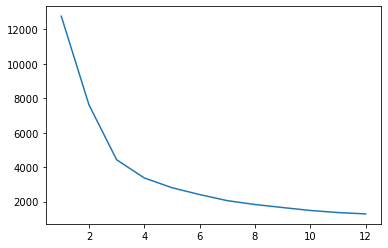

In [14]:
km_analyse(data_out_rem_std)

silhouette score close to 1 is better and CH score - higher the better

Robust scaler

In [15]:
rb=RobustScaler()
data_out_rem_rob=pd.DataFrame(rb.fit_transform(data_out_rem[['Recency','Frequency','Monetary']]))

Error list:  [17883.746044532443, 9077.61115027084, 6770.424877778792, 4968.966894607362, 3925.789955803294, 3261.6232515121474, 2883.928429597543, 2554.6333579052507, 2274.7465163367006, 2049.686595828846, 1898.514532514065, 1743.9650462632478]
Silhouette_score:
     Cluster  Silhouette_score
0         2          0.624003
1         3          0.447708
2         4          0.446076
3         5          0.450081
4         6          0.447074
5         7          0.440146
6         8          0.398590
7         9          0.402179
8        10          0.371696
9        11          0.365704
10       12          0.362048
Calinski Harabasz score:
     Cluster     CH score
0         2  4125.809212
1         3  3489.724977
2         4  3682.912765
3         5  3777.669548
4         6  3809.722642
5         7  3682.432186
6         8  3640.640584
7         9  3641.965449
8        10  3643.684124
9        11  3573.391539
10       12  3569.786353


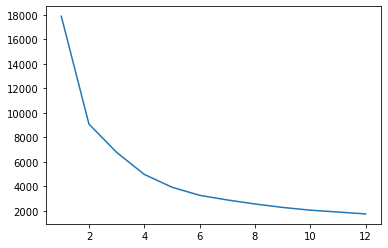

In [16]:
km_analyse(data_out_rem_rob)

Min max scaler

In [17]:
min_max=MinMaxScaler()
data_out_rem_minmax=pd.DataFrame(min_max.fit_transform(data_out_rem[['Recency','Frequency','Monetary']]))

Error list:  [456.3436015734227, 201.18361527702962, 124.82814670788696, 93.44447884680636, 75.6292726385948, 64.86420905122472, 55.2959323711434, 49.088882412185484, 43.49430438483745, 39.78603425490797, 36.72238351573971, 33.6550525884132]
Silhouette_score:
     Cluster  Silhouette_score
0         2          0.572607
1         3          0.553103
2         4          0.491314
3         5          0.444268
4         6          0.389785
5         7          0.396091
6         8          0.375959
7         9          0.376467
8        10          0.376656
9        11          0.380635
10       12          0.364625
Calinski Harabasz score:
     Cluster     CH score
0         2  5394.060086
1         3  5646.177370
2         4  5503.036943
3         5  5348.633880
4         6  5128.888897
5         7  5134.950107
6         8  5033.468592
7         9  5037.921890
8        10  4938.465974
9        11  4849.597094
10       12  4844.524603


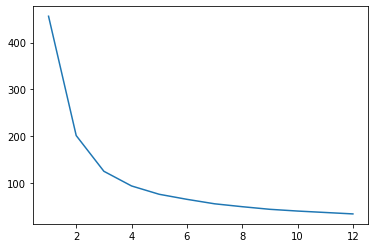

In [18]:
km_analyse(data_out_rem_minmax)

Min max scaler seems to perform well in light of silhouette score and calinski harabasz score

**K means model with min max scaled data**

In [19]:
label=km_model_eval(3,data_out_rem_minmax)

Cluster Labels:
 [2 0 0 ... 0 2 0]


In [20]:
np.bincount(label)

array([2718, 1041,  496], dtype=int64)

In [21]:
data_out_rem['Labels']=label
data_out_rem

,CustomerID,Recency,Frequency,Monetary,Labels
1,12347.0,1,182,4310.00,2
2,12348.0,74,31,1797.24,0
3,12349.0,18,73,1757.55,0
4,12350.0,309,17,334.40,1
5,12352.0,35,85,2506.04,0
...,...,...,...,...,...
4333,18280.0,277,10,180.60,1
4334,18281.0,180,7,80.82,1
4335,18282.0,7,12,178.05,0
4336,18283.0,3,756,2094.88,2


**Analysis with model**

<AxesSubplot:xlabel='Labels', ylabel='Recency'>

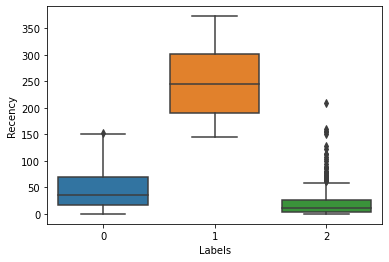

In [22]:
sns.boxplot(x='Labels',y='Recency',data=data_out_rem)

- The customers in cluster 2 has the highest recency which means they have to be concentrated upon to bring them back as loyal customers.
 * Giving seasonal discounts to them or offering them coupons with a short time validity can make them come back and getting a review from them can help the turn to loyal customers

- The customers in cluster 0 have very low recency which suggests that they have been loyal customers so far. But the outliers in cluster 0 suggests that these customers are on the verge of being lost

<AxesSubplot:xlabel='Labels', ylabel='Frequency'>

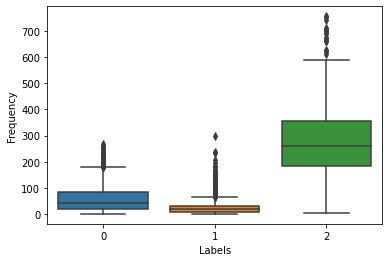

In [23]:
sns.boxplot(x='Labels',y='Frequency',data=data_out_rem)

- Cluster 0 has made the highest number of transactions.
- Cluster 2 on the other hand have made least transactions on an average and to bring them back,
 - Ask feedback from them if they are in need of any new items in the store
 - Give offers on specific products to increase the number of transactions and give a chance for them to buy back

<AxesSubplot:xlabel='Labels', ylabel='Monetary'>

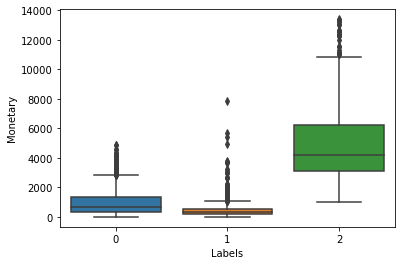

In [24]:
sns.boxplot(x='Labels',y='Monetary',data=data_out_rem)

- Cluster 0 customers have spent a good average amount towards the transaction
- Cluster 2 on the other hand have not performed well towards the monetary aspect of the store, except a few outliers


# Agglomerative clustering

**Data with log**

In [25]:
data_log=np.log(data[['Recency','Frequency','Monetary']])

In [26]:
data_log

,Recency,Frequency,Monetary
0,5.783825,0.000000,11.253942
1,0.000000,5.204007,8.368693
2,4.304065,3.433987,7.494007
3,2.890372,4.290459,7.471676
4,5.733341,2.833213,5.812338
...,...,...,...
4333,5.624018,2.302585,5.196285
4334,5.192957,1.945910,4.392224
4335,1.945910,2.484907,5.182064
4336,1.098612,6.628041,7.647252


**Standardisation**

In [27]:
minmax=MinMaxScaler()
data_minmax=pd.DataFrame(minmax.fit_transform(data[['Recency','Frequency','Monetary']]))
data_minmax.columns=['Recency','Frequency','Monetary']

In [28]:
data_minmax

,Recency,Frequency,Monetary
0,0.871314,0.000000,0.275443
1,0.002681,0.023069,0.015368
2,0.198391,0.003824,0.006401
3,0.048257,0.009177,0.006259
4,0.828418,0.002039,0.001180
...,...,...,...
4333,0.742627,0.001147,0.000631
4334,0.482574,0.000765,0.000275
4335,0.018767,0.001402,0.000622
4336,0.008043,0.096227,0.007463


In [29]:
sc=StandardScaler()
data_std=pd.DataFrame(sc.fit_transform(data[['Recency','Frequency','Monetary']]))
data_std.columns=['Recency','Frequency','Monetary']

In [30]:
data_log_minmax=pd.DataFrame(minmax.fit_transform(np.log(data[['Frequency','Monetary']])))
data_log_minmax.columns=['Frequency','Monetary']
data_log_minmax['Recency']=minmax.fit_transform(np.log(data[['Recency']]+1))

In [31]:
data_log_std=pd.DataFrame(sc.fit_transform(np.log(data[['Frequency','Monetary']])))
data_log_std.columns=['Frequency','Monetary']
data_log_std['Recency']=sc.fit_transform(pd.DataFrame(np.log(data['Recency']+1)))

In [32]:
grid={'linkage':['single','complete','average','ward'],
      'affinity':['euclidean','l1','l2','manhattan','cosine'],
      'n_clusters':range(2,10)}

In [33]:
agg=AgglomerativeClustering()

In [34]:
link=RandomizedSearchCV(estimator=agg,param_distributions=grid,n_iter=100,cv=3,verbose=2,random_state=100,scoring='adjusted_rand_score')

In [35]:
link.fit(data_minmax)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ........affinity=l1, linkage=complete, n_clusters=7; total time=   0.4s
[CV] END ........affinity=l1, linkage=complete, n_clusters=7; total time=   0.3s
[CV] END ........affinity=l1, linkage=complete, n_clusters=7; total time=   0.3s
[CV] END .affinity=euclidean, linkage=complete, n_clusters=5; total time=   0.3s
[CV] END .affinity=euclidean, linkage=complete, n_clusters=5; total time=   0.3s
[CV] END .affinity=euclidean, linkage=complete, n_clusters=5; total time=   0.3s
[CV] END ......affinity=cosine, linkage=single, n_clusters=2; total time=   0.0s
[CV] END ......affinity=cosine, linkage=single, n_clusters=2; total time=   0.0s
[CV] END ......affinity=cosine, linkage=single, n_clusters=2; total time=   0.0s
[CV] END .affinity=euclidean, linkage=complete, n_clusters=9; total time=   0.3s
[CV] END .affinity=euclidean, linkage=complete, n_clusters=9; total time=   0.3s
[CV] END .affinity=euclidean, linkage=complete

RandomizedSearchCV(cv=3, estimator=AgglomerativeClustering(), n_iter=100,
                   param_distributions={'affinity': ['euclidean', 'l1', 'l2',
                                                     'manhattan', 'cosine'],
                                        'linkage': ['single', 'complete',
                                                    'average', 'ward'],
                                        'n_clusters': range(2, 10)},
                   random_state=100, scoring='adjusted_rand_score', verbose=2)

In [36]:
link.best_params_

{'n_clusters': 7, 'linkage': 'complete', 'affinity': 'l1'}

In [37]:
link.fit(data_std)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ........affinity=l1, linkage=complete, n_clusters=7; total time=   0.3s
[CV] END ........affinity=l1, linkage=complete, n_clusters=7; total time=   0.4s
[CV] END ........affinity=l1, linkage=complete, n_clusters=7; total time=   0.2s
[CV] END .affinity=euclidean, linkage=complete, n_clusters=5; total time=   0.3s
[CV] END .affinity=euclidean, linkage=complete, n_clusters=5; total time=   0.3s
[CV] END .affinity=euclidean, linkage=complete, n_clusters=5; total time=   0.3s
[CV] END ......affinity=cosine, linkage=single, n_clusters=2; total time=   0.0s
[CV] END ......affinity=cosine, linkage=single, n_clusters=2; total time=   0.0s
[CV] END ......affinity=cosine, linkage=single, n_clusters=2; total time=   0.0s
[CV] END .affinity=euclidean, linkage=complete, n_clusters=9; total time=   0.3s
[CV] END .affinity=euclidean, linkage=complete, n_clusters=9; total time=   0.3s
[CV] END .affinity=euclidean, linkage=complete

RandomizedSearchCV(cv=3, estimator=AgglomerativeClustering(), n_iter=100,
                   param_distributions={'affinity': ['euclidean', 'l1', 'l2',
                                                     'manhattan', 'cosine'],
                                        'linkage': ['single', 'complete',
                                                    'average', 'ward'],
                                        'n_clusters': range(2, 10)},
                   random_state=100, scoring='adjusted_rand_score', verbose=2)

In [38]:
link.best_params_

{'n_clusters': 7, 'linkage': 'complete', 'affinity': 'l1'}

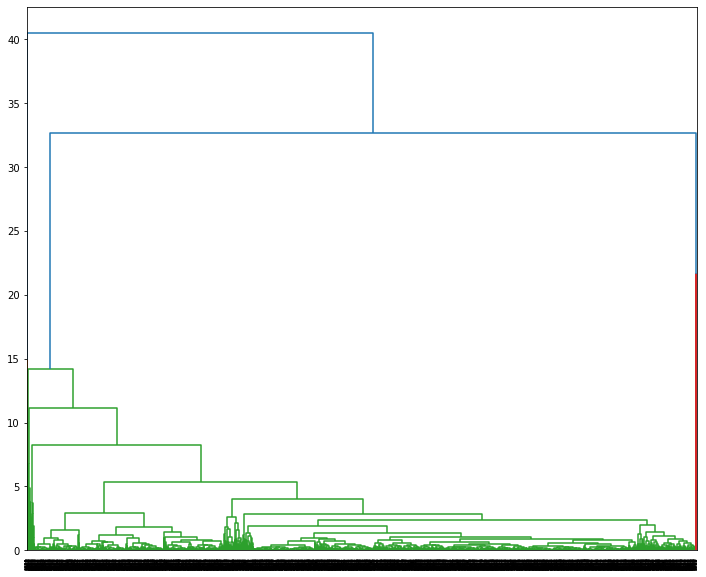

In [39]:
plt.figure(figsize=(12,10))
dendrogram=sch.dendrogram(sch.linkage(data_std,method='complete',metric='euclidean'))

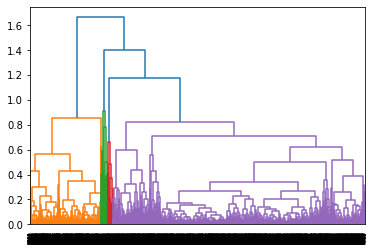

In [81]:
dendrogram=sch.dendrogram(sch.linkage(data_out_rem_minmax,method='complete',metric='euclidean'))

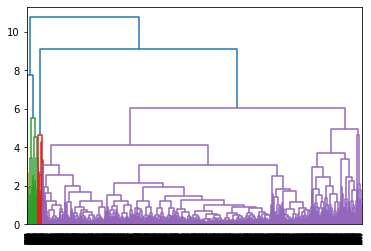

In [82]:
dendrogram=sch.dendrogram(sch.linkage(data_out_rem_std,method='complete',metric='euclidean'))

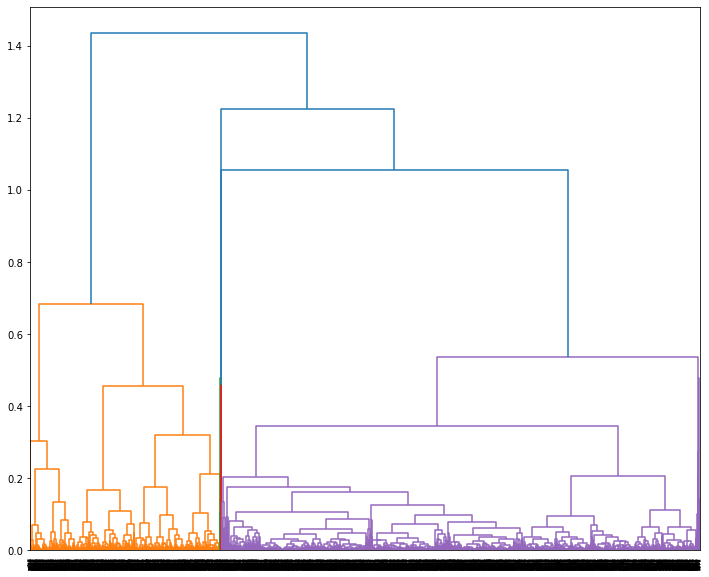

In [40]:
plt.figure(figsize=(12,10))
dendrogram=sch.dendrogram(sch.linkage(data_minmax,method='complete',metric='euclidean'))

In [41]:
def agglo_analyse(data):
    sil=[]
    cal=[]
    for i in range(2,13):
        agg=AgglomerativeClustering(n_clusters=i,affinity='l1',linkage='complete')
        y_pred=agg.fit_predict(data)
        sil.append(silhouette_score(data,y_pred))
        cal.append(calinski_harabasz_score(data,y_pred))
    print('\nSilhouette score:\n ',pd.DataFrame({'cluster':range(2,13),'Silhouette score':sil}))
    print('\nCalinski Harabasz score:\n ',pd.DataFrame({'cluster':range(2,13),'CH score':cal}))

In [42]:
agglo_analyse(data_std)


Silhouette score:
      cluster  Silhouette score
0         2          0.945553
1         3          0.929693
2         4          0.911286
3         5          0.771116
4         6          0.770826
5         7          0.770968
6         8          0.716933
7         9          0.716937
8        10          0.697164
9        11          0.694917
10       12          0.694754

Calinski Harabasz score:
      cluster     CH score
0         2  1155.004312
1         3  1569.682455
2         4  1153.166374
3         5  1053.444119
4         6   865.703615
5         7   747.156494
6         8   755.511251
7         9   679.758396
8        10   613.105839
9        11   569.855096
10       12   522.572276


In [43]:
agglo_analyse(data_minmax)


Silhouette score:
      cluster  Silhouette score
0         2          0.524663
1         3          0.487828
2         4          0.694121
3         5          0.660353
4         6          0.647083
5         7          0.621896
6         8          0.621744
7         9          0.532389
8        10          0.532566
9        11          0.535169
10       12          0.535314

Calinski Harabasz score:
      cluster     CH score
0         2    65.942605
1         3    41.291694
2         4  5342.715270
3         5  4058.428035
4         6  3273.908415
5         7  4942.859670
6         8  4246.573939
7         9  6809.432428
8        10  6118.041948
9        11  8830.832703
10       12  8081.566072


In [44]:
agglo_analyse(data_log_minmax)


Silhouette score:
      cluster  Silhouette score
0         2          0.360583
1         3          0.271233
2         4          0.284013
3         5          0.176149
4         6          0.169247
5         7          0.168462
6         8          0.130760
7         9          0.182773
8        10          0.178494
9        11          0.178375
10       12          0.169193

Calinski Harabasz score:
      cluster     CH score
0         2  3423.150494
1         3  2121.991899
2         4  2117.523969
3         5  1838.554023
4         6  1583.433347
5         7  1331.877174
6         8  1449.399197
7         9  1705.320616
8        10  1561.045613
9        11  1415.244449
10       12  1421.053921


In [45]:
agglo_analyse(data_log_std)


Silhouette score:
      cluster  Silhouette score
0         2          0.317883
1         3          0.224374
2         4          0.225681
3         5          0.227566
4         6          0.220364
5         7          0.189024
6         8          0.213590
7         9          0.202718
8        10          0.202785
9        11          0.197358
10       12          0.195982

Calinski Harabasz score:
      cluster     CH score
0         2  2382.425012
1         3  2112.741650
2         4  1443.579761
3         5  1408.150509
4         6  1190.572093
5         7  1074.750434
6         8  1423.513541
7         9  1351.018710
8        10  1207.330680
9        11  1177.499177
10       12  1118.215065


**We see that with data_std dataset model gives good score(both ch and silhouette) for n_clusters=3.**
**But, more than 90% of the data points are in one cluster**

**we will henceforth try with data_minmax n_clusters = 4**

**Lets classify the clusters based on both these**

In [46]:
agg=AgglomerativeClustering(n_clusters=3,affinity='l1',linkage='complete')
label=agg.fit_predict(data_std)

In [47]:
data_final=data[['CustomerID','Recency','Frequency','Monetary']]
data_final['Labels']=label
data_final

,CustomerID,Recency,Frequency,Monetary,Labels
0,12346.0,325,1,77183.60,2
1,12347.0,1,182,4310.00,2
2,12348.0,74,31,1797.24,2
3,12349.0,18,73,1757.55,2
4,12350.0,309,17,334.40,2
...,...,...,...,...,...
4333,18280.0,277,10,180.60,2
4334,18281.0,180,7,80.82,2
4335,18282.0,7,12,178.05,2
4336,18283.0,3,756,2094.88,2


In [48]:
np.unique(label)

array([0, 1, 2], dtype=int64)

In [49]:
np.bincount(label)

array([   7,    4, 4327], dtype=int64)

<AxesSubplot:xlabel='Labels', ylabel='Recency'>

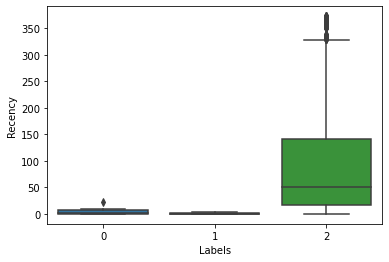

In [50]:
sns.boxplot(x='Labels',y='Recency',data=data_final)

<AxesSubplot:xlabel='Labels', ylabel='Frequency'>

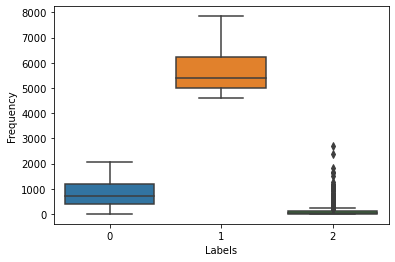

In [51]:
sns.boxplot(x='Labels',y='Frequency',data=data_final)

<AxesSubplot:xlabel='Labels', ylabel='Monetary'>

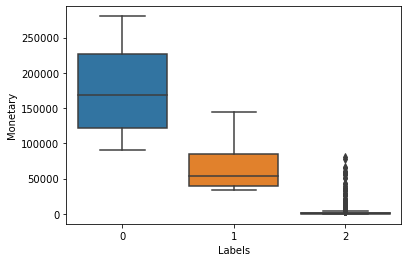

In [52]:
sns.boxplot(x='Labels',y='Monetary',data=data_final)

In [53]:
agg=AgglomerativeClustering(n_clusters=4,affinity='l1',linkage='complete')
label1=agg.fit_predict(data_minmax)

In [54]:
data_final1=data[['CustomerID','Recency','Frequency','Monetary']]
data_final1['Labels']=label1
data_final1

,CustomerID,Recency,Frequency,Monetary,Labels
0,12346.0,325,1,77183.60,1
1,12347.0,1,182,4310.00,3
2,12348.0,74,31,1797.24,3
3,12349.0,18,73,1757.55,3
4,12350.0,309,17,334.40,1
...,...,...,...,...,...
4333,18280.0,277,10,180.60,1
4334,18281.0,180,7,80.82,1
4335,18282.0,7,12,178.05,3
4336,18283.0,3,756,2094.88,3


In [55]:
np.bincount(label1)

array([  14, 1145,    8, 3171], dtype=int64)

<AxesSubplot:xlabel='Labels', ylabel='Recency'>

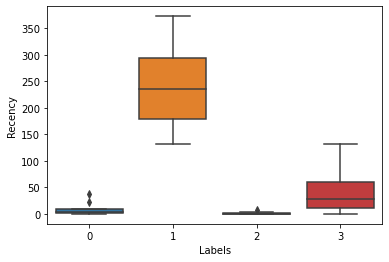

In [56]:
sns.boxplot(x='Labels',y='Recency',data=data_final1)

<AxesSubplot:xlabel='Labels', ylabel='Frequency'>

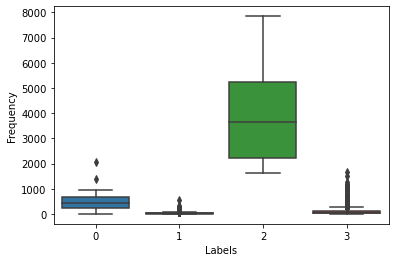

In [57]:
sns.boxplot(x='Labels',y='Frequency',data=data_final1)

<AxesSubplot:xlabel='Labels', ylabel='Monetary'>

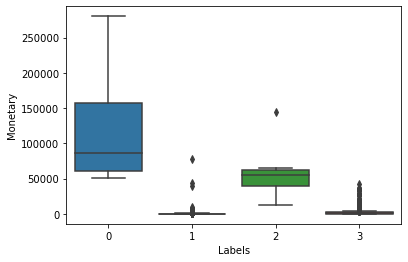

In [58]:
sns.boxplot(x='Labels',y='Monetary',data=data_final1)

# DB Scan

In [59]:
hyper={'eps':[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5.5,6,6.5,7,7.5,8],'min_samples':[3,5,8,10,15,19,22,25]}

In [60]:
db=DBSCAN()

In [61]:
hyp_db=RandomizedSearchCV(estimator=db,param_distributions=hyper,
                          n_iter=100,cv=3,verbose=2,random_state=100,
                          scoring='fowlkes_mallows_score')

In [62]:
hyp_db.fit(data_std)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ............................eps=4.5, min_samples=19; total time=   0.2s
[CV] END ............................eps=4.5, min_samples=19; total time=   0.1s
[CV] END ............................eps=4.5, min_samples=19; total time=   0.1s
[CV] END ............................eps=3.5, min_samples=22; total time=   0.2s
[CV] END ............................eps=3.5, min_samples=22; total time=   0.2s
[CV] END ............................eps=3.5, min_samples=22; total time=   0.1s
[CV] END ............................eps=2.5, min_samples=19; total time=   0.2s
[CV] END ............................eps=2.5, min_samples=19; total time=   0.2s
[CV] END ............................eps=2.5, min_samples=19; total time=   0.1s
[CV] END ..............................eps=3, min_samples=22; total time=   0.2s
[CV] END ..............................eps=3, min_samples=22; total time=   0.2s
[CV] END ..............................eps=3, 

RandomizedSearchCV(cv=3, estimator=DBSCAN(), n_iter=100,
                   param_distributions={'eps': [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,
                                                4.5, 5.5, 6, 6.5, 7, 7.5, 8],
                                        'min_samples': [3, 5, 8, 10, 15, 19, 22,
                                                        25]},
                   random_state=100, scoring='fowlkes_mallows_score',
                   verbose=2)

In [63]:
hyp_db.best_params_

{'min_samples': 19, 'eps': 4.5}

In [64]:
hyp_db.fit(data_minmax)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ............................eps=4.5, min_samples=19; total time=   0.1s
[CV] END ............................eps=4.5, min_samples=19; total time=   0.1s
[CV] END ............................eps=4.5, min_samples=19; total time=   0.1s
[CV] END ............................eps=3.5, min_samples=22; total time=   0.1s
[CV] END ............................eps=3.5, min_samples=22; total time=   0.1s
[CV] END ............................eps=3.5, min_samples=22; total time=   0.1s
[CV] END ............................eps=2.5, min_samples=19; total time=   0.1s
[CV] END ............................eps=2.5, min_samples=19; total time=   0.1s
[CV] END ............................eps=2.5, min_samples=19; total time=   0.1s
[CV] END ..............................eps=3, min_samples=22; total time=   0.1s
[CV] END ..............................eps=3, min_samples=22; total time=   0.1s
[CV] END ..............................eps=3, 

RandomizedSearchCV(cv=3, estimator=DBSCAN(), n_iter=100,
                   param_distributions={'eps': [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,
                                                4.5, 5.5, 6, 6.5, 7, 7.5, 8],
                                        'min_samples': [3, 5, 8, 10, 15, 19, 22,
                                                        25]},
                   random_state=100, scoring='fowlkes_mallows_score',
                   verbose=2)

In [65]:
hyp_db.best_params_

{'min_samples': 19, 'eps': 4.5}

In [66]:
param={'eps':[4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9],'min_samples':[16,16,18,19,20,21]}

In [67]:
grid_db=GridSearchCV(estimator=db,param_grid=param,cv=3,verbose=2,scoring='fowlkes_mallows_score')

In [68]:
grid_db.fit(data_std)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ............................eps=4.2, min_samples=16; total time=   0.2s
[CV] END ............................eps=4.2, min_samples=16; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=16; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=16; total time=   0.2s
[CV] END ............................eps=4.2, min_samples=16; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=16; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=18; total time=   0.2s
[CV] END ............................eps=4.2, min_samples=18; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=18; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=19; total time=   0.2s
[CV] END ............................eps=4.2, min_samples=19; total time=   0.1s
[CV] END ............................eps=4.2, m

GridSearchCV(cv=3, estimator=DBSCAN(),
             param_grid={'eps': [4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9],
                         'min_samples': [16, 16, 18, 19, 20, 21]},
             scoring='fowlkes_mallows_score', verbose=2)

In [69]:
grid_db.best_params_

{'eps': 4.2, 'min_samples': 16}

In [70]:
grid_db.fit(data_minmax)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ............................eps=4.2, min_samples=16; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=16; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=16; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=16; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=16; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=16; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=18; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=18; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=18; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=19; total time=   0.1s
[CV] END ............................eps=4.2, min_samples=19; total time=   0.1s
[CV] END ............................eps=4.2, m

GridSearchCV(cv=3, estimator=DBSCAN(),
             param_grid={'eps': [4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9],
                         'min_samples': [16, 16, 18, 19, 20, 21]},
             scoring='fowlkes_mallows_score', verbose=2)

In [71]:
grid_db.best_params_

{'eps': 4.2, 'min_samples': 16}

**Fit the model with best parameters**

In [72]:
db=DBSCAN(eps=0.085,min_samples=9)

In [73]:
db.fit(data_std)

DBSCAN(eps=0.085, min_samples=9)

In [74]:
set(db.labels_)

{-1, 0, 1, 2, 3}

In [75]:
silhouette_score(data_std,db.labels_)

-0.19595881465783263

In [76]:
db1=DBSCAN(eps=0.085,min_samples=16)
db1.fit(data_minmax)


DBSCAN(eps=0.085, min_samples=16)

In [77]:
set(db1.labels_)

{-1, 0}

DB scan is not working great as its taking almost every point into a single cluster

In [78]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_std)
distances, indices = nbrs.kneighbors(data_std)

(0.0, 0.2)

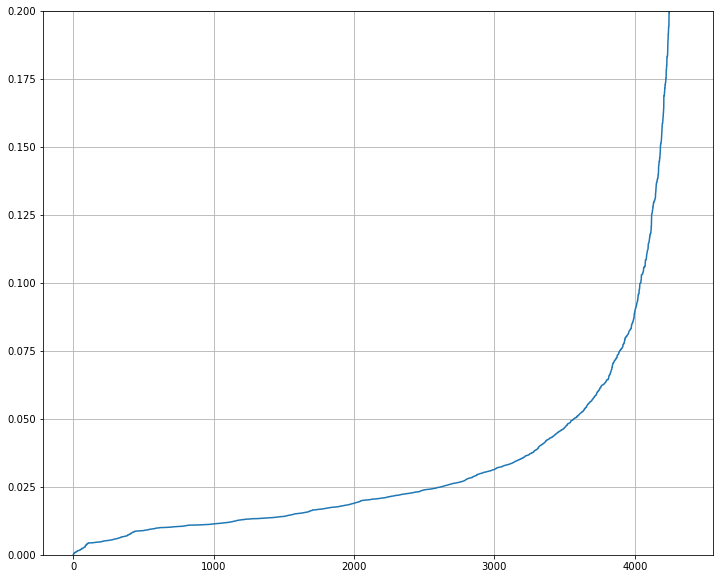

In [79]:
plt.figure(figsize=(12,10))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.grid()
plt.ylim(0,0.2)

In [80]:
distances

array([1.11257052e-05, 1.11257052e-05, 5.05107017e-04, ...,
       7.54566074e+00, 9.09221720e+00, 1.22588691e+01])